In [2]:
from preprocess import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from huggingface_hub import hf_hub_download
import fasttext

/Users/JasonLebov_1/anaconda3/envs/env1/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
fraud_data_raw = pd.read_csv('/Users/JasonLebov_1/Desktop/CS 334/Final Project/Final Project Data/Original/fraud test.csv')

In [4]:
# Step 1: Dropping Features
features_drop = ['Unnamed: 0', 'street', 'city', 'state', 'zip', 'unix_time', 'trans_num', 'cc_num']
drop_features_df = drop_features(fraud_data_raw, features_drop)

In [5]:
# Step *: Removing 'fraud_' prefix from merchant
removed_prefix_df = remove_prefix(drop_features_df, 'merchant')

In [6]:
# Step 2: Feature Extraction --> 'trans_date_trans_time'
     # Converting to DateTime Object
col_name_1 = 'trans_date_trans_time'
col_format_1 = '%d/%m/%Y %H:%M'
fixed_dt_1 = convert_dt(removed_prefix_df, col_name_1, col_format_1)

    # Extracting Values
fixed_dt_1['transaction_month'] = fixed_dt_1['trans_date_trans_time'].dt.month
fixed_dt_1['transaction_day'] = fixed_dt_1['trans_date_trans_time'].dt.day
fixed_dt_1['transaction_time'] = fixed_dt_1['trans_date_trans_time'].dt.strftime('%H:%M')

    # Converting Time to Categorical Ranges
fixed_dt_1 = convert_time_ranges(fixed_dt_1, 'transaction_time')

    # Dropping Original 'trans_date_trans_time' 
fixed_dt_1 = drop_features(fixed_dt_1, ['trans_date_trans_time'])

In [7]:
# Step 2 [cont]: Feature Extraction --> Year Born from 'dob'
     # Converting to DateTime Object
col_name_2 = 'dob'
col_format_2 = '%d/%m/%Y'
fixed_dt_2 = convert_dt(fixed_dt_1, col_name_2, col_format_2)

    # Extracting Values
fixed_dt_2['year_born'] = fixed_dt_2['dob'].dt.year

    # Dropping Original 'dob' 
final_extraction_df = drop_features(fixed_dt_2, ['dob'])

In [8]:
# Step 3: One Hot Encode
cols_encode = ['category', 'transaction_time']
one_hot_df = one_hot_encode(final_extraction_df, cols_encode)

In [9]:
# Step 4: Label Encoding ['merchant', 'job']

features = ['merchant', 'job', 'gender']
df_encoded = label_encode(one_hot_df, features)

In [10]:
# Step 4: Convert Names to Numers (Label Encoding + FastTest)

    # Creating FastText Model
fastText_model = fasttext.load_model(hf_hub_download("facebook/fasttext-language-identification", "model.bin"))

    # Lowercasing Names for Consistency
df_encoded['last'] = fraud_data_raw['last'].str.lower()
df_encoded['last'] = fraud_data_raw['last'].str.lower()

first_name_encode = name_converter(fastText_model, df_encoded, 'first')
final_encoded =  name_converter(fastText_model, first_name_encode, 'last')

In [11]:
# Step 5: Move Label Feature to End of DF
numeric_df_final = label_end(final_encoded, ['is_fraud'])

In [12]:
# Step 6: Pearson Correlation Matrix
feature_corr = pearson_matrix(df_encoded)

<Axes: title={'center': 'Pearson Correlation Matrix'}>

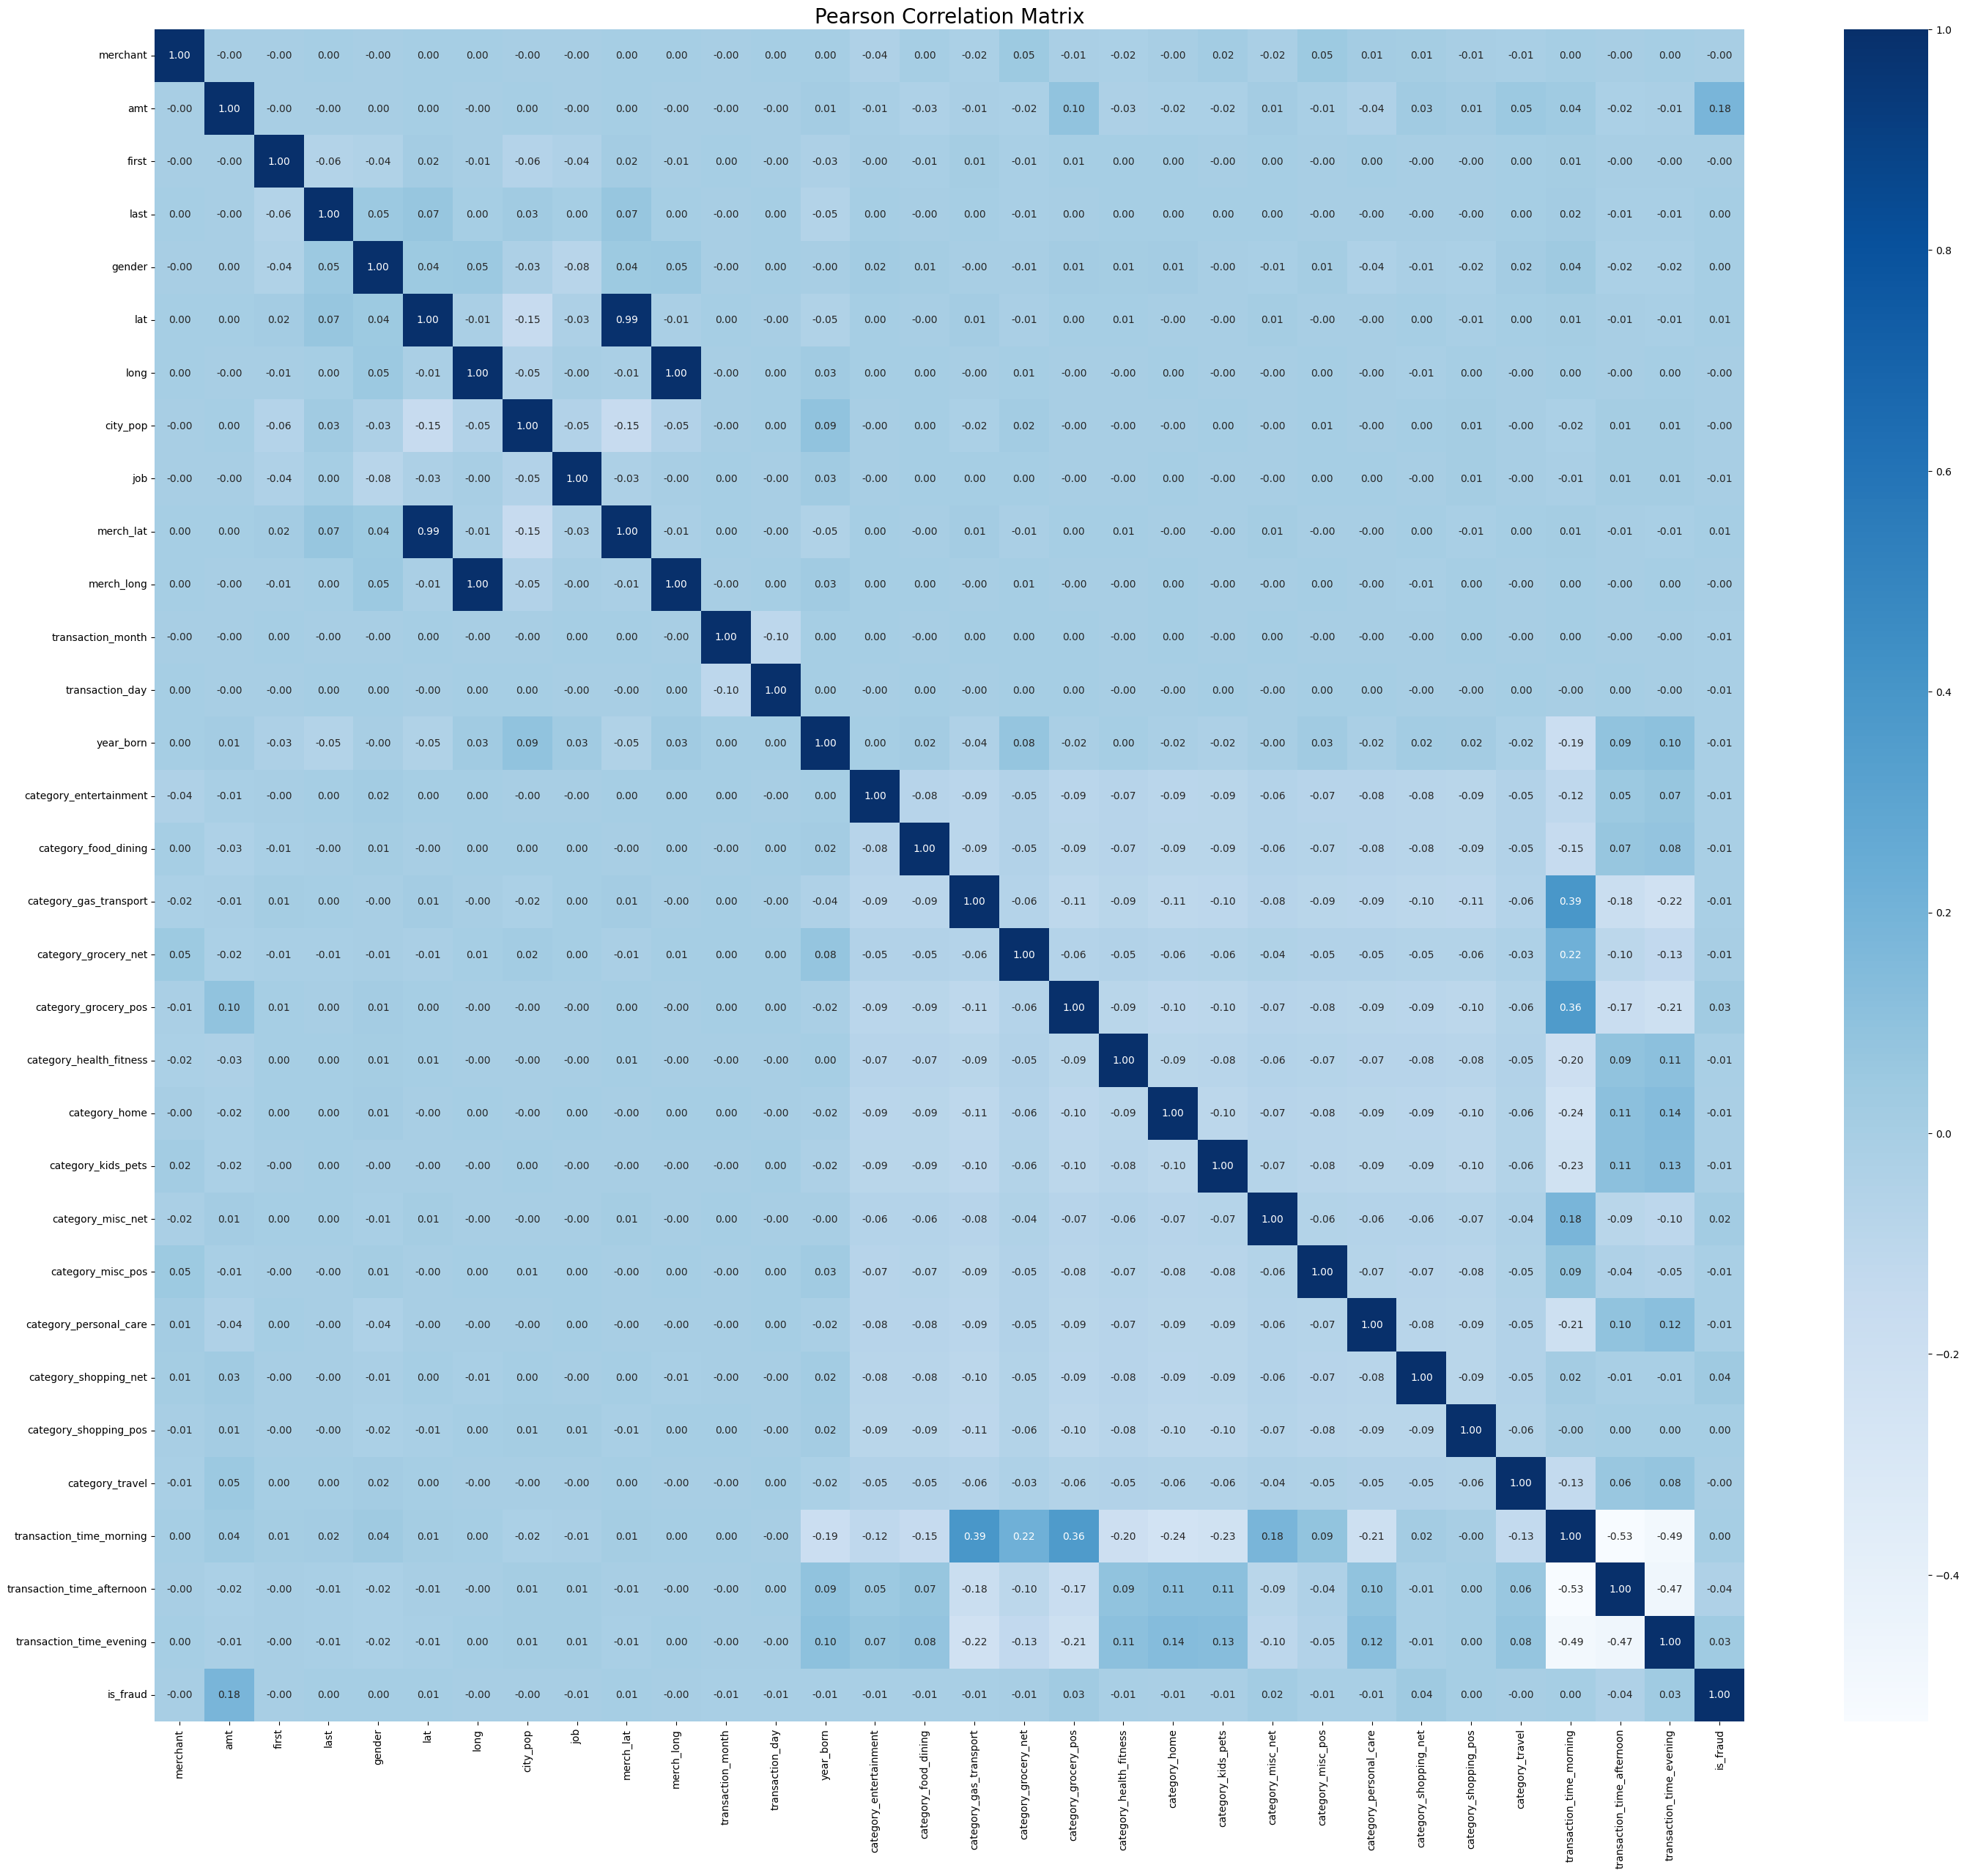

In [13]:
# Graph of Pearson Correlation Matrices - Features
plt.figure(figsize=(35,30)) # 35, 30
plt.title('Pearson Correlation Matrix', fontsize=20)
sns.heatmap(feature_corr, annot=True, cmap=plt.cm.Blues, fmt='.2f')

In [14]:
# Step 6 [cont]: Dropping Delta Values
delta_drops = ['merch_lat', 'merch_long']
final_raw = drop_features(numeric_df_final, delta_drops)

In [15]:
# Step 7: Making W/ & W/ Out Personal Information
pi_raw = final_raw.copy()

pi_cols_drop = ['lat', 'long', 'year_born', 'gender', 'job', 'first', 'last']
pi_raw_filter = final_raw.copy()
no_pi_raw = drop_features(pi_raw_filter, pi_cols_drop)

In [18]:
# Step 8: Train-Test Splits
pi_fraud_train, pi_fraud_test = data_split(pi_raw)
no_pi_fraud_train, no_pi_fraud_test = data_split(no_pi_raw)

In [21]:
# Step 9: Min-Max Scaling
pi_cols_scale = pi_raw.iloc[:, :-1].columns
no_pi_cols_scale = no_pi_raw.iloc[:, :-1].columns

pi_train_final, pi_test_final = min_max_scale(pi_fraud_train, pi_fraud_test, pi_cols_scale)
no_pi_train_final, no_pi_test_final = min_max_scale(no_pi_fraud_train, no_pi_fraud_test, no_pi_cols_scale)

In [22]:
# Step *: Making xFeat & y

pi_train_xFeat = pi_train_final.iloc[:, :-1]
pi_train_y = pi_train_final.iloc[:, -1]
pi_test_xFeat = pi_test_final.iloc[:, :-1]
pi_test_y = pi_test_final.iloc[:, -1]

no_pi_train_xFeat = no_pi_train_final.iloc[:, :-1]
no_pi_train_y = no_pi_train_final.iloc[:, -1]
no_pi_test_xFeat = no_pi_test_final.iloc[:, :-1]
no_pi_test_y = no_pi_test_final.iloc[:, -1]

In [23]:
# Step 10: SMOTE for Training Data

final_pi_train_xFeat, final_pi_train_y = smote(pi_train_xFeat, pi_train_y)
final_no_pi_train_xFeat, final_no_pi_train_y = smote(no_pi_train_xFeat, no_pi_train_y)

final_pi_test_xFeat = pi_test_xFeat.copy()
final_pi_test_y = pi_test_y.copy()

final_no_pi_test_xFeat = no_pi_test_xFeat.copy()
final_no_pi_test_y = no_pi_test_y.copy()

In [24]:
# Step 11: Saving to CSVs (11 CSVs)

  # Save ' '_final_full
final_raw.to_csv('/Users/JasonLebov_1/Desktop/CS 334/Final Project/Final Project Data/final_full_raw.csv', index=False)

  # Save Splits (NO PI & PI)
pi_raw.to_csv('/Users/JasonLebov_1/Desktop/CS 334/Final Project/Final Project Data/pi_full_raw.csv', index=False)
no_pi_raw.to_csv('/Users/JasonLebov_1/Desktop/CS 334/Final Project/Final Project Data/no_pi_full_raw.csv', index=False)

  # Save Train-Test-Splits (xFeat & y) of PI & NO PI
final_pi_train_xFeat.to_csv('/Users/JasonLebov_1/Desktop/CS 334/Final Project/Final Project Data/pi_train_xFeat.csv', index=False)
final_pi_train_y.to_csv('/Users/JasonLebov_1/Desktop/CS 334/Final Project/Final Project Data/pi_train_y.csv', index=False)

final_no_pi_train_xFeat.to_csv('/Users/JasonLebov_1/Desktop/CS 334/Final Project/Final Project Data/no_pi_train_xFeat.csv', index=False)
final_no_pi_train_y.to_csv('/Users/JasonLebov_1/Desktop/CS 334/Final Project/Final Project Data/no_pi_train_y.csv', index=False)

final_pi_test_xFeat.to_csv('/Users/JasonLebov_1/Desktop/CS 334/Final Project/Final Project Data/pi_test_xFeat.csv', index=False)
final_pi_test_y.to_csv('/Users/JasonLebov_1/Desktop/CS 334/Final Project/Final Project Data/pi_test_y.csv', index=False)

final_no_pi_test_xFeat.to_csv('/Users/JasonLebov_1/Desktop/CS 334/Final Project/Final Project Data/no_pi_test_xFeat.csv', index=False)
final_no_pi_test_y.to_csv('/Users/JasonLebov_1/Desktop/CS 334/Final Project/Final Project Data/no_pi_test_y.csv', index=False)
